In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, NamedTuple, Tuple

In [4]:
results = pd.read_csv('../results/processed_data.csv')
results.head()

,timestamp,user_id,day,quiz_id,image_index,illusion_filename,user_answer,response_time,speed_group,display_time,correct_answer,line_length1,line_length2,actual_difference,arrow_length,angle,arrow_color,is_control,is_correct
0,2024-11-05 01:34:15,Haleygundie,1,1,0,muller_lyer_day1_illusion13.svg,Left,7.209,Group 1 - Slow,5.0,Right,185,200,-15,20,36,black,False,False
1,2024-11-05 01:34:22,Haleygundie,1,1,1,muller_lyer_day1_illusion27.svg,Same length,5.427,Group 1 - Slow,5.0,Same length,200,200,0,20,36,red,False,True
2,2024-11-05 01:34:27,Haleygundie,1,1,2,muller_lyer_day1_illusion46.svg,Left,4.179,Group 1 - Slow,5.0,Left,205,180,25,20,36,red,False,True
3,2024-11-05 01:34:35,Haleygundie,1,1,3,muller_lyer_day1_illusion37.svg,Right,6.192,Group 1 - Slow,5.0,Right,185,200,-15,20,36,red,False,True
4,2024-11-05 01:34:41,Haleygundie,1,1,4,muller_lyer_day1_illusion42.svg,Right,5.236,Group 1 - Slow,5.0,Right,185,220,-35,20,36,red,False,True


In [5]:
class ParticipantStats(NamedTuple):
    user_id: str
    total_trials: int
    correct_black: int
    total_black: int
    correct_red: int
    total_red: int
    avg_rt_fast: float
    avg_rt_slow: float
    correct_fast: int
    total_fast: int
    correct_slow: int
    total_slow: int

In [6]:
def calculate_participant_stats(df: pd.DataFrame) -> Dict[str, ParticipantStats]:
    """Calculate statistics for each participant."""
    stats = {}
    
    for user_id in df['user_id'].unique():
        user_data = df[df['user_id'] == user_id]
        
        # Calculate color-based stats
        black_trials = user_data[user_data['arrow_color'] == 'black']
        red_trials = user_data[user_data['arrow_color'] == 'red']
        
        # Calculate speed-based stats
        fast_trials = user_data[user_data['speed_group'].str.contains('Fast')]
        slow_trials = user_data[user_data['speed_group'].str.contains('Slow')]
        
        stats[user_id] = ParticipantStats(
            user_id=user_id,
            total_trials=len(user_data),
            correct_black=len(black_trials[black_trials['is_correct']]),
            total_black=len(black_trials),
            correct_red=len(red_trials[red_trials['is_correct']]),
            total_red=len(red_trials),
            avg_rt_fast=fast_trials['response_time'].mean(),
            avg_rt_slow=slow_trials['response_time'].mean(),
            correct_fast=len(fast_trials[fast_trials['is_correct']]),
            total_fast=len(fast_trials),
            correct_slow=len(slow_trials[slow_trials['is_correct']]),
            total_slow=len(slow_trials)
        )
    
    return stats

In [7]:
def create_comparison_visualization(stats: Dict[str, ParticipantStats]) -> None:
    """Create a visualization comparing fast vs slow performance."""
    # Prepare data for plotting
    plot_data = []
    
    for stat in stats.values():
        # Only include data points where trials exist
        if stat.total_fast > 0:
            plot_data.append({
                'user_id': stat.user_id,
                'Speed': 'Fast',
                'Accuracy (%)': (stat.correct_fast / stat.total_fast * 100)
            })
        if stat.total_slow > 0:
            plot_data.append({
                'user_id': stat.user_id,
                'Speed': 'Slow',
                'Accuracy (%)': (stat.correct_slow / stat.total_slow * 100)
            })
    
    plot_data = pd.DataFrame(plot_data)
    
    if len(plot_data) == 0:
        print("Warning: No data available for visualization")
        return
    
    # Create the visualization
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Create box plot with individual points
    sns.boxplot(data=plot_data, x='Speed', y='Accuracy (%)', color='lightgray')
    sns.swarmplot(data=plot_data, x='Speed', y='Accuracy (%)', color='darkblue', size=8)
    
    # Customize the plot
    plt.title('Accuracy Comparison: Fast vs Slow Display Times', pad=20)
    plt.ylabel('Accuracy (%)')
    
    # Add mean lines for each condition
    means = plot_data.groupby('Speed')['Accuracy (%)'].mean()
    for i, speed in enumerate(means.index):
        plt.hlines(means[speed], i-0.3, i+0.3, color='red', linestyles='dashed', label='Mean' if i == 0 else '')
    
    plt.legend()
    plt.tight_layout()

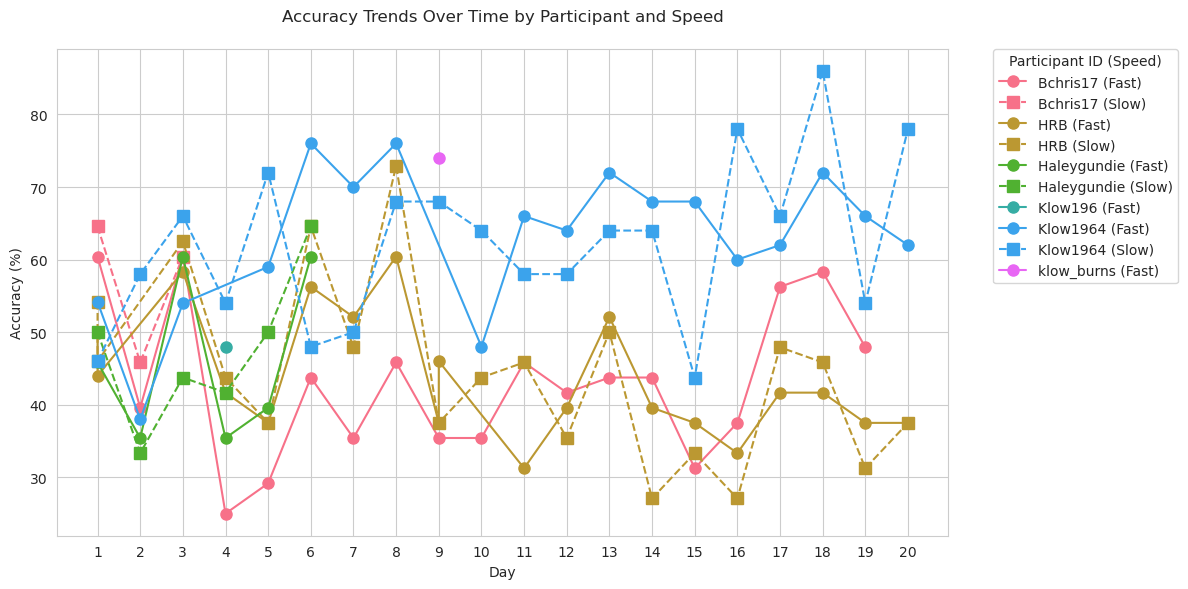

In [8]:
def create_accuracy_trend_visualization(df: pd.DataFrame, users_to_include: list = None) -> None:
    """
    Create a line plot showing accuracy trends over days for selected participants, separated by speed.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    users_to_include : list, optional
        List of user IDs to include in the visualization. If None, includes all users.
    """
    # Filter for specified users if provided
    if users_to_include is not None:
        df = df[df['user_id'].isin(users_to_include)]
        if df.empty:
            print("No data found for specified users.")
            return
    
    # Calculate daily accuracy for each participant and speed condition
    daily_accuracy = df.groupby(['user_id', 'day', 'speed_group']).agg({
        'is_correct': ['count', 'sum']
    }).reset_index()
    
    # Calculate accuracy percentage
    daily_accuracy.columns = ['user_id', 'day', 'speed_group', 'total_trials', 'correct_trials']
    daily_accuracy['accuracy'] = (daily_accuracy['correct_trials'] / 
                                daily_accuracy['total_trials'] * 100)
    
    # Simplify speed group names
    daily_accuracy['speed'] = daily_accuracy['speed_group'].apply(
        lambda x: 'Fast' if 'Fast' in x else 'Slow'
    )
    
    # Create the visualization
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Get unique users for color assignment
    users = sorted(df['user_id'].unique())
    colors = sns.color_palette("husl", n_colors=len(users))
    
    # Create line plot for each user and speed condition
    for i, user in enumerate(users):
        user_data = daily_accuracy[daily_accuracy['user_id'] == user]
        
        # Plot fast condition (solid line)
        fast_data = user_data[user_data['speed'] == 'Fast']
        if not fast_data.empty:
            plt.plot(fast_data['day'], fast_data['accuracy'], 
                    color=colors[i], linestyle='-', marker='o',
                    label=f'{user} (Fast)', markersize=8)
        
        # Plot slow condition (dashed line)
        slow_data = user_data[user_data['speed'] == 'Slow']
        if not slow_data.empty:
            plt.plot(slow_data['day'], slow_data['accuracy'], 
                    color=colors[i], linestyle='--', marker='s',
                    label=f'{user} (Slow)', markersize=8)
    
    # Customize the plot
    plt.title('Accuracy Trends Over Time by Participant and Speed', pad=20)
    plt.xlabel('Day')
    plt.ylabel('Accuracy (%)')
    
    # Adjust x-axis to show only integer days
    plt.xticks(sorted(daily_accuracy['day'].unique()))
    
    # Add legend with a title
    plt.legend(title='Participant ID (Speed)',
              bbox_to_anchor=(1.05, 1), 
              loc='upper left',
              borderaxespad=0)
    
    # Ensure no labels are cut off
    plt.tight_layout()

# Example usage:
# For all users
create_accuracy_trend_visualization(results)

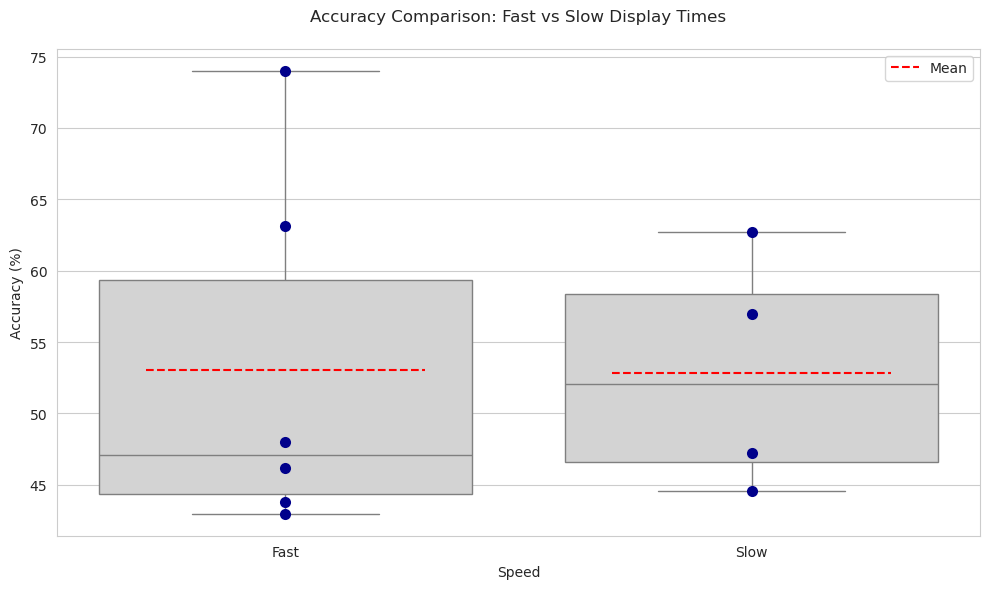

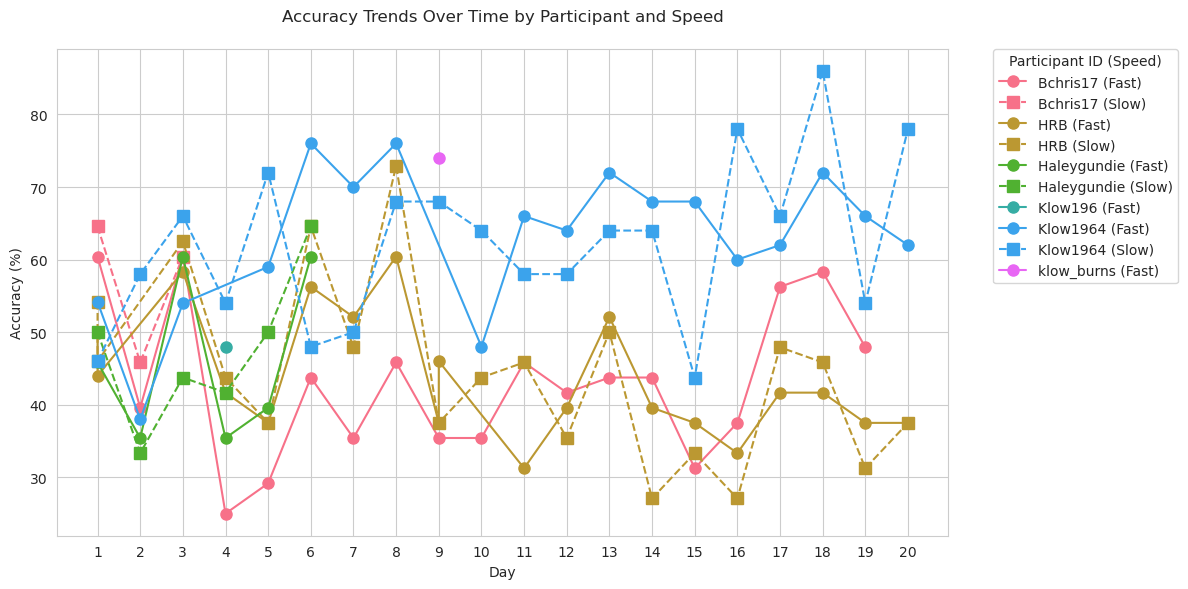

In [9]:
# Calculate statistics for all participants
participant_stats = calculate_participant_stats(results)

# Create visualizations
create_comparison_visualization(participant_stats)
plt.show()

create_accuracy_trend_visualization(results)
plt.show()

In [10]:
def remap_user_ids(df: pd.DataFrame, 
                   id_column: str,
                   mapping_dict: dict,
                   verbose: bool = True) -> pd.DataFrame:
    """
    Remap user IDs in a DataFrame based on a provided mapping dictionary.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing user IDs to be remapped
    id_column : str
        The name of the column containing user IDs
    mapping_dict : dict
        Dictionary mapping incorrect user IDs to their correct versions
        e.g., {'old_id1': 'new_id1', 'old_id2': 'new_id2'}
    verbose : bool, default=True
        If True, prints summary of changes made
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with remapped user IDs
    """
    # Create a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Keep track of changes for reporting
    changes = {}
    
    # Apply the mapping
    for old_id, new_id in mapping_dict.items():
        mask = df_clean[id_column] == old_id
        count = mask.sum()
        if count > 0:
            df_clean.loc[mask, id_column] = new_id
            changes[old_id] = {'new_id': new_id, 'count': count}
    
    # Print summary if verbose is True
    if verbose and changes:
        print("\nUser ID Remapping Summary:")
        print("-" * 50)
        for old_id, info in changes.items():
            print(f"Renamed {info['count']} instances of '{old_id}' to '{info['new_id']}'")
        print(f"\nUnique user IDs after remapping: {df_clean[id_column].nunique()}")
    
    return df_clean


id_mapping = {
    'Klow196': 'Klow1964',
    'klow_burns': 'Klow1964'
}

# Apply the remapping
results_clean = remap_user_ids(results, 
                             id_column='user_id', 
                             mapping_dict=id_mapping)

# Optional: Verify the changes
print("\nUnique user IDs in cleaned dataset:")
print(sorted(results_clean['user_id'].unique()))


User ID Remapping Summary:
--------------------------------------------------
Renamed 50 instances of 'Klow196' to 'Klow1964'
Renamed 50 instances of 'klow_burns' to 'Klow1964'

Unique user IDs after remapping: 4

Unique user IDs in cleaned dataset:
['Bchris17', 'HRB', 'Haleygundie', 'Klow1964']


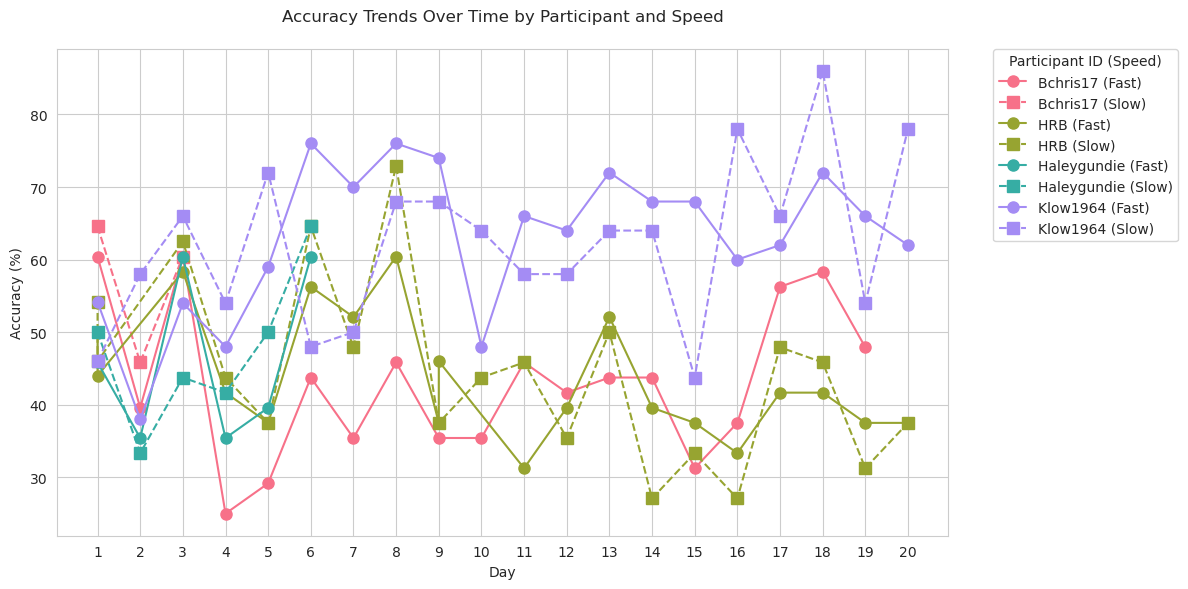

In [11]:
create_accuracy_trend_visualization(results_clean)
plt.show()

In [12]:
# clean_data_sample = results_clean.sample(100)
# clean_data_sample.to_csv('../results/clean_data_sample.csv', index=False)

In [13]:
import pandas as pd
from typing import Dict, Tuple

def identify_duplicate_trials(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identify cases where users answered the same question multiple times in a quiz on the same day.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing duplicate trial entries
    """
    # Count occurrences of each question by each user in each quiz
    trial_counts = df.groupby(['user_id', 'day', 'quiz_id', 'image_index']).size().reset_index(name='attempts')
    
    # Filter for cases with multiple attempts
    duplicates = trial_counts[trial_counts['attempts'] > 1]
    
    if len(duplicates) > 0:
        print(f"\nFound {len(duplicates)} instances of duplicate trial attempts:")
        for _, row in duplicates.iterrows():
            print(f"User {row['user_id']} attempted question {row['image_index']} "
                  f"in quiz {row['quiz_id']} on day {row['day']} {row['attempts']} times")
    
    return duplicates

def identify_incomplete_quizzes(df: pd.DataFrame, expected_trials: int) -> pd.DataFrame:
    """
    Identify quizzes where users didn't complete all trials.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    expected_trials : int
        Expected number of trials per quiz
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing incomplete quiz information
    """
    # Count trials per quiz for each user
    trial_counts = df.groupby(['user_id', 'day', 'quiz_id']).agg(
        unique_trials=('image_index', 'nunique'),
        total_trials=('image_index', 'count')
    ).reset_index()
    
    # Identify incomplete quizzes or quizzes with duplicate trials
    incomplete = trial_counts[
        (trial_counts['unique_trials'] != expected_trials) | 
        (trial_counts['total_trials'] != expected_trials)
    ]
    
    if len(incomplete) > 0:
        print(f"\nFound {len(incomplete)} problematic quizzes:")
        for _, row in incomplete.iterrows():
            if row['unique_trials'] != row['total_trials']:
                print(f"User {row['user_id']} quiz {row['quiz_id']} day {row['day']}: "
                      f"{row['unique_trials']} unique trials, {row['total_trials']} total trials "
                      f"(indicates duplicate questions)")
            else:
                print(f"User {row['user_id']} quiz {row['quiz_id']} day {row['day']}: "
                      f"completed {row['unique_trials']}/{expected_trials} trials")
    
    return incomplete

def check_data_quality(df: pd.DataFrame, expected_trials: int = 48) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Run all data quality checks and return results.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    expected_trials : int, default=48
        Expected number of trials per quiz
    
    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame]
        Duplicate trials DataFrame, Incomplete quizzes DataFrame
    """
    print(f"Running data quality checks (expected {expected_trials} trials per quiz)...")
    
    duplicates = identify_duplicate_trials(df)
    incomplete = identify_incomplete_quizzes(df, expected_trials)
    
    # Get detailed information about specific cases
    if len(duplicates) > 0:
        print("\nDetailed information for duplicate trials:")
        for _, dup in duplicates.iterrows():
            relevant_trials = df[
                (df['user_id'] == dup['user_id']) & 
                (df['day'] == dup['day']) & 
                (df['quiz_id'] == dup['quiz_id']) &
                (df['image_index'] == dup['image_index'])
            ]
            print(f"\nDetailed trials for duplicate question {dup['image_index']} "
                  f"by {dup['user_id']} on day {dup['day']} quiz {dup['quiz_id']}:")
            print(relevant_trials[['timestamp', 'image_index', 'user_answer', 'is_correct']].sort_values('timestamp'))
    
    return duplicates, incomplete

# Example usage
# Check with default 48 trials
# duplicates, incomplete = check_data_quality(results)

# Or specify a different number of expected trials
duplicates, incomplete = check_data_quality(results_clean, expected_trials=49)

Running data quality checks (expected 49 trials per quiz)...

Found 152 instances of duplicate trial attempts:
User Bchris17 attempted question 30 in quiz 60 on day 16 2 times
User Klow1964 attempted question 0 in quiz 18 on day 5 2 times
User Klow1964 attempted question 1 in quiz 18 on day 5 2 times
User Klow1964 attempted question 2 in quiz 18 on day 5 2 times
User Klow1964 attempted question 3 in quiz 18 on day 5 2 times
User Klow1964 attempted question 4 in quiz 18 on day 5 2 times
User Klow1964 attempted question 5 in quiz 18 on day 5 2 times
User Klow1964 attempted question 6 in quiz 18 on day 5 2 times
User Klow1964 attempted question 7 in quiz 18 on day 5 2 times
User Klow1964 attempted question 8 in quiz 18 on day 5 2 times
User Klow1964 attempted question 9 in quiz 18 on day 5 2 times
User Klow1964 attempted question 10 in quiz 18 on day 5 2 times
User Klow1964 attempted question 11 in quiz 18 on day 5 2 times
User Klow1964 attempted question 12 in quiz 18 on day 5 2 times
Us

In [14]:
def remove_duplicate_trials(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Remove duplicate trials from the dataset, keeping only the first instance.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    verbose : bool, default=True
        If True, prints summary of removed duplicates
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame with duplicates removed
    """
    # Create a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Sort by timestamp to ensure we keep the first instance
    df_clean = df_clean.sort_values('timestamp')
    
    # Count initial trials
    initial_count = len(df_clean)
    
    # Drop duplicates based on user_id, day, quiz_id, and image_index
    df_clean = df_clean.drop_duplicates(
        subset=['user_id', 'day', 'quiz_id', 'image_index'],
        keep='first'
    )
    
    # Count removed trials
    removed_count = initial_count - len(df_clean)
    
    if verbose and removed_count > 0:
        print(f"\nRemoved {removed_count} duplicate trials:")
        print(f"Initial trial count: {initial_count}")
        print(f"Final trial count: {len(df_clean)}")
        
        # Get counts by user
        user_counts = df.groupby('user_id').size() - df_clean.groupby('user_id').size()
        users_with_duplicates = user_counts[user_counts > 0]
        
        print("\nDuplicates removed by user:")
        for user, count in users_with_duplicates.items():
            print(f"{user}: {count} duplicate trials removed")
    
    return df_clean

def clean_and_validate_data(df: pd.DataFrame, expected_trials: int = 48) -> pd.DataFrame:
    """
    Clean data by removing duplicates and validate the results.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    expected_trials : int, default=48
        Expected number of trials per quiz
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame
    """
    print("Starting data cleaning process...")
    
    # Remove duplicates
    df_clean = remove_duplicate_trials(df)
    
    # Validate results
    print("\nValidating cleaned data...")
    duplicates, incomplete = check_data_quality(df_clean, expected_trials)
    
    if len(duplicates) == 0:
        print("\nAll duplicates successfully removed!")
    else:
        print("\nWarning: Some duplicates remain after cleaning!")
    
    # Check if any quizzes are now incomplete due to duplicate removal
    if len(incomplete) > 0:
        print("\nNote: Some quizzes are incomplete after duplicate removal.")
        print("You may want to handle these cases separately.")
    
    return df_clean

# Example usage
# Clean the data
results_drop_dups = clean_and_validate_data(results_clean, expected_trials=50)

# Optional: Compare trial counts before and after cleaning
print("\nTrial counts by user (before cleaning):")
print(results.groupby('user_id').size())
print("\nTrial counts by user (after cleaning):")
print(results_drop_dups.groupby('user_id').size())

Starting data cleaning process...

Removed 152 duplicate trials:
Initial trial count: 5704
Final trial count: 5552

Duplicates removed by user:
Bchris17: 1 duplicate trials removed
Klow1964: 151 duplicate trials removed

Validating cleaned data...
Running data quality checks (expected 50 trials per quiz)...

Found 74 problematic quizzes:
User Bchris17 quiz 0 day 1: completed 48/50 trials
User Bchris17 quiz 1 day 1: completed 48/50 trials
User Bchris17 quiz 4 day 2: completed 48/50 trials
User Bchris17 quiz 5 day 2: completed 48/50 trials
User Bchris17 quiz 8 day 3: completed 48/50 trials
User Bchris17 quiz 9 day 3: completed 48/50 trials
User Bchris17 quiz 12 day 4: completed 48/50 trials
User Bchris17 quiz 16 day 5: completed 48/50 trials
User Bchris17 quiz 20 day 6: completed 48/50 trials
User Bchris17 quiz 24 day 7: completed 48/50 trials
User Bchris17 quiz 28 day 8: completed 48/50 trials
User Bchris17 quiz 32 day 9: completed 48/50 trials
User Bchris17 quiz 36 day 10: completed 48

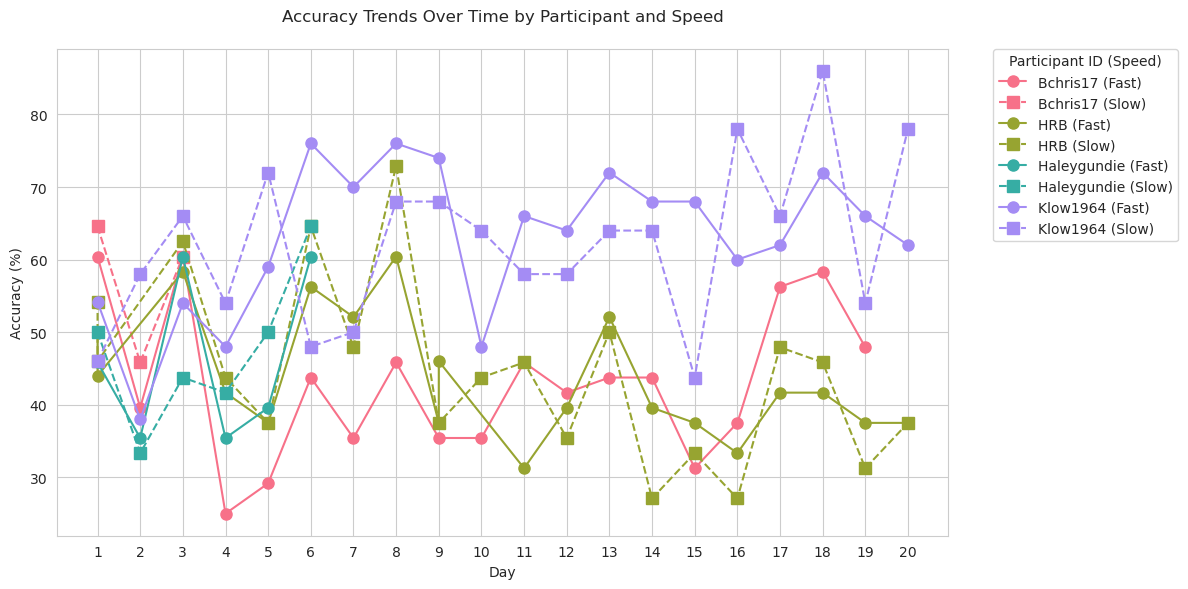

In [15]:
create_accuracy_trend_visualization(results_clean)
plt.show()

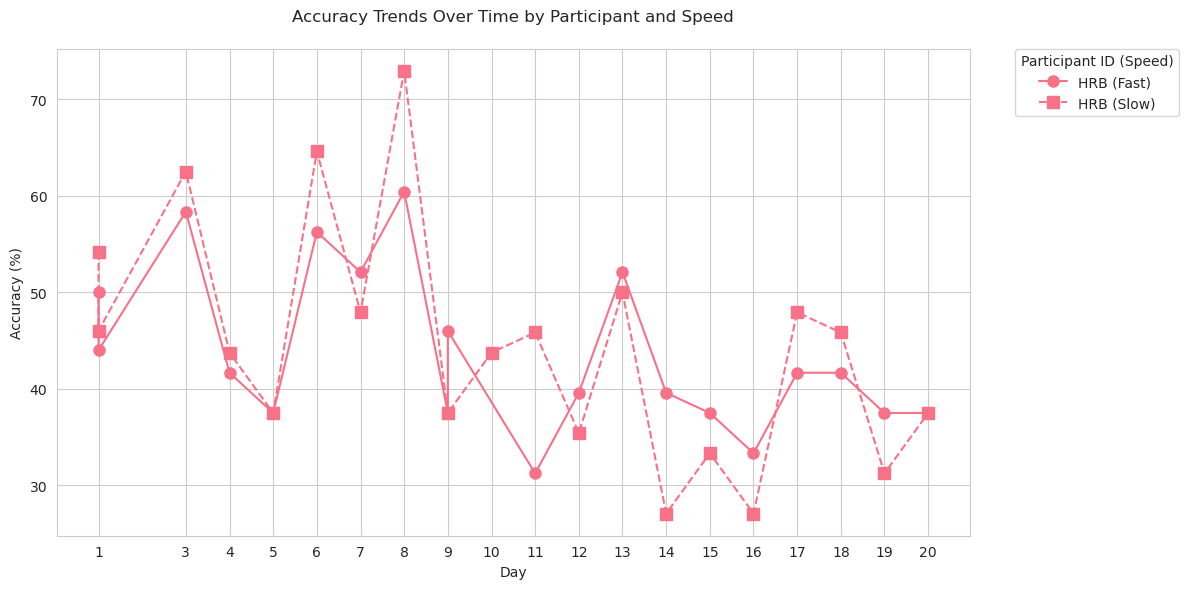

In [16]:
create_accuracy_trend_visualization(results_drop_dups, users_to_include=['HRB'])

In [17]:
def fix_and_renumber_quizzes(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Fix quiz day assignments and renumber quizzes based on day and group.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    verbose : bool, default=True
        If True, prints details of corrections
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with corrected day assignments and renumbered quizzes
    """
    df_fixed = df.copy()
    
    def get_group_num(speed_group):
        return int(speed_group.split('Group ')[1][0])
    
    # Add group number column
    df_fixed['group_num'] = df_fixed['speed_group'].apply(get_group_num)
    
    # Process each user separately
    for user in df_fixed['user_id'].unique():
        if verbose:
            print(f"\nProcessing user: {user}")
            
        user_mask = df_fixed['user_id'] == user
        user_data = df_fixed[user_mask]
        
        # First, identify and fix day assignments
        problematic_days = user_data.groupby('day').agg({
            'quiz_id': 'nunique',
            'group_num': 'nunique'
        }).reset_index()
        
        # Find days with too many quizzes
        for _, row in problematic_days.iterrows():
            day = row['day']
            day_mask = user_mask & (df_fixed['day'] == day)
            day_data = df_fixed[day_mask]
            
            # Sort quizzes by timestamp to maintain order
            quizzes = day_data.groupby('quiz_id')['timestamp'].min().sort_values()
            quiz_list = quizzes.index.tolist()
            
            if len(quiz_list) > 2:
                if verbose:
                    print(f"Day {day}: Found {len(quiz_list)} quizzes: {quiz_list}")
                
                # Move excess quizzes to next day
                for i, quiz_id in enumerate(quiz_list[2:], start=2):
                    new_day = day + 1
                    quiz_mask = day_mask & (df_fixed['quiz_id'] == quiz_id)
                    df_fixed.loc[quiz_mask, 'day'] = new_day
                    if verbose:
                        print(f"Moving quiz {quiz_id} to day {new_day}")
        
        # Now renumber all quizzes based on final day assignments
        for day in sorted(df_fixed[user_mask]['day'].unique()):
            day_mask = user_mask & (df_fixed['day'] == day)
            day_data = df_fixed[day_mask]
            
            for group in sorted(day_data['group_num'].unique()):
                group_mask = day_mask & (df_fixed['group_num'] == group)
                group_data = df_fixed[group_mask]
                
                # Get quizzes for this day/group
                quizzes = sorted(group_data['quiz_id'].unique())
                
                # Calculate new quiz numbers
                base_quiz_num = (day - 1) * 4
                if group == 1:
                    new_numbers = [base_quiz_num, base_quiz_num + 1]
                else:  # group == 2
                    new_numbers = [base_quiz_num + 2, base_quiz_num + 3]
                
                # Apply new numbers
                for old_id, new_id in zip(quizzes, new_numbers[:len(quizzes)]):
                    quiz_mask = group_mask & (df_fixed['quiz_id'] == old_id)
                    if verbose:
                        print(f"Day {day} Group {group}: Remapping quiz {old_id} to {new_id}")
                    df_fixed.loc[quiz_mask, 'quiz_id'] = new_id
    
    # Remove temporary group number column
    df_fixed = df_fixed.drop('group_num', axis=1)
    
    return df_fixed

# Example usage
results_fixed = fix_and_renumber_quizzes(results_clean)

# Verify the changes
def verify_quiz_assignments(df: pd.DataFrame):
    """Print summary of quiz assignments per user per day."""
    for user in df['user_id'].unique():
        user_data = df[df['user_id'] == user]
        quiz_summary = user_data.groupby(['day'])[['quiz_id', 'speed_group']].agg({
            'quiz_id': ['count', 'unique'],
            'speed_group': 'unique'
        }).reset_index()
        quiz_summary.columns = ['day', 'total_trials', 'unique_quizzes', 'speeds']
        print(f"\nUser: {user}")
        print(quiz_summary)

# Run verification
verify_quiz_assignments(results_fixed)


Processing user: Haleygundie
Day 1 Group 1: Remapping quiz 0 to 0
Day 1 Group 1: Remapping quiz 1 to 1
Day 2 Group 1: Remapping quiz 4 to 4
Day 2 Group 1: Remapping quiz 5 to 5
Day 3 Group 1: Remapping quiz 8 to 8
Day 3 Group 1: Remapping quiz 9 to 9
Day 4 Group 1: Remapping quiz 12 to 12
Day 4 Group 1: Remapping quiz 13 to 13
Day 5 Group 1: Remapping quiz 16 to 16
Day 5 Group 1: Remapping quiz 17 to 17
Day 6 Group 1: Remapping quiz 20 to 20
Day 6 Group 1: Remapping quiz 21 to 21

Processing user: HRB
Day 1: Found 4 quizzes: [0, 1, 2, 3]
Moving quiz 2 to day 2
Moving quiz 3 to day 2
Day 9: Found 3 quizzes: [32, 33, 34]
Moving quiz 34 to day 10
Day 1 Group 1: Remapping quiz 0 to 0
Day 1 Group 1: Remapping quiz 1 to 1
Day 2 Group 2: Remapping quiz 2 to 6
Day 2 Group 2: Remapping quiz 3 to 7
Day 3 Group 1: Remapping quiz 8 to 8
Day 3 Group 1: Remapping quiz 9 to 9
Day 4 Group 1: Remapping quiz 12 to 12
Day 4 Group 1: Remapping quiz 13 to 13
Day 5 Group 1: Remapping quiz 16 to 16
Day 5 Gr

In [21]:
def standardize_user_groups(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Standardize user groups by identifying each user's majority group and
    correcting any outlier group assignments while preserving fast/slow designation.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    verbose : bool, default=True
        If True, prints details of corrections
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with standardized group assignments
    """
    df_fixed = df.copy()
    
    # Function to extract just the group number
    def get_group_num(speed_group):
        return int(speed_group.split('Group ')[1][0])
    
    # Function to extract just the speed designation
    def get_speed(speed_group):
        return 'Fast' if 'Fast' in speed_group else 'Slow'
    
    # Process each user separately
    for user in df_fixed['user_id'].unique():
        user_data = df_fixed[df_fixed['user_id'] == user]
        
        # Get group counts for this user
        group_counts = user_data['speed_group'].apply(get_group_num).value_counts()
        majority_group = group_counts.index[0]
        
        if len(group_counts) > 1 and verbose:
            print(f"\nProcessing user: {user}")
            print(f"Group counts: {group_counts.to_dict()}")
            print(f"Majority group: Group {majority_group}")
        
        # Check for mismatched groups
        for idx, row in user_data.iterrows():
            current_group = get_group_num(row['speed_group'])
            current_speed = get_speed(row['speed_group'])
            
            if current_group != majority_group:
                # Create new speed_group string
                new_speed_group = f"Group {majority_group} - {current_speed}"
                
                if verbose:
                    print(f"Changing {row['speed_group']} to {new_speed_group} "
                          f"for quiz {row['quiz_id']} on day {row['day']}")
                
                df_fixed.loc[idx, 'speed_group'] = new_speed_group
    
    # Verify changes
    if verbose:
        print("\nFinal group distribution by user:")
        for user in df_fixed['user_id'].unique():
            user_groups = df_fixed[df_fixed['user_id'] == user]['speed_group'].unique()
            print(f"\n{user}: {sorted(user_groups)}")
    
    return df_fixed

# Example usage
results_standardized = standardize_user_groups(results_fixed)

# Verification function
def verify_group_assignments(df: pd.DataFrame):
    """Print summary of group assignments per user."""
    for user in df['user_id'].unique():
        user_data = df[df['user_id'] == user]
        print(f"\nUser: {user}")
        print("Group distribution:")
        print(user_data['speed_group'].value_counts())
        print("\nUnique speed_group values:")
        print(sorted(user_data['speed_group'].unique()))

# Run verification
verify_group_assignments(results_standardized)


Processing user: HRB
Group counts: {1: 1776, 2: 150}
Majority group: Group 1
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 on day 2
Changing Group 2 - Fast to Group 1 - Fast for quiz 6 o

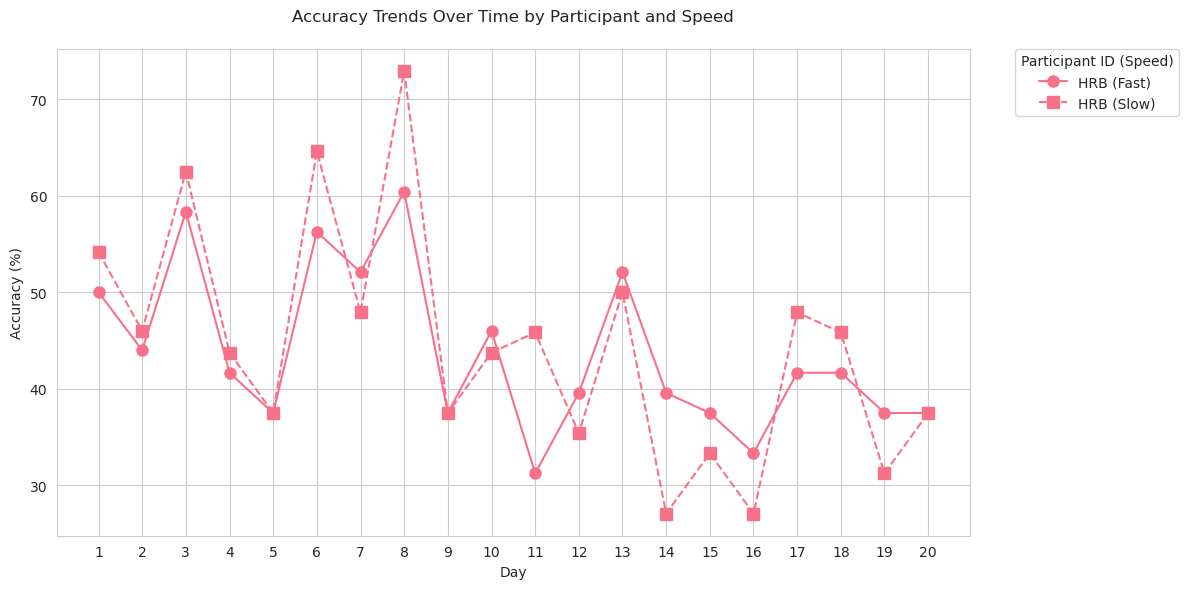

In [22]:
create_accuracy_trend_visualization(results_standardized, users_to_include=['HRB'])

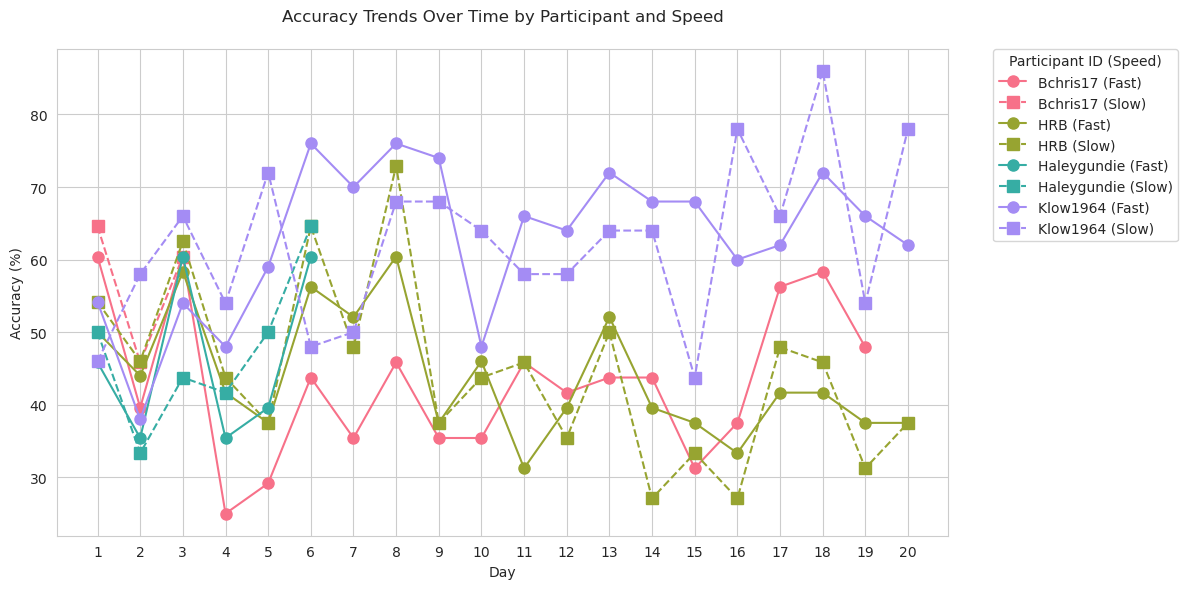

In [23]:
create_accuracy_trend_visualization(results_standardized)

In [24]:
results_standardized.to_csv('../results/cleaned_data.csv', index=False)
# results_sample = results_fixed.sample(100)
# results_sample.to_csv('../results/cleaned_data_sample.csv', index=False)